In [1]:
import os, shutil, pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import os, shutil, pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keithlowton","key":"f96b94ee8178d07d81a253c5457d447a"}'}

In [3]:
!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:20<00:00, 45.4MB/s]
100% 812M/812M [00:20<00:00, 42.1MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

In [7]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cat_vs_dog")

In [8]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Model

In [9]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [11]:
model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [12]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [13]:
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [14]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [15]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [16]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [17]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.ckpt",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 47ms/step - loss: 0.7058 - accuracy: 0.5025 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 3s 40ms/step - loss: 0.6938 - accuracy: 0.5285 - val_loss: 0.6922 - val_accuracy: 0.5030
Epoch 3/30
63/63 [==============================] - 2s 38ms/step - loss: 0.6883 - accuracy: 0.5595 - val_loss: 0.6343 - val_accuracy: 0.6360
Epoch 4/30
63/63 [==============================] - 1s 22ms/step - loss: 0.6501 - accuracy: 0.6145 - val_loss: 1.7623 - val_accuracy: 0.5010
Epoch 5/30
63/63 [==============================] - 2s 37ms/step - loss: 0.6404 - accuracy: 0.6600 - val_loss: 0.5961 - val_accuracy: 0.6750
Epoch 6/30
63/63 [==============================] - 2s 37ms/step - loss: 0.5923 - accuracy: 0.6800 - val_loss: 0.5848 - val_accuracy: 0.6880
Epoch 7/30
63/63 [==============================] - 2s 37ms/step - loss: 0.5490 - accuracy: 0.7125 - val_loss: 0.5459 - val_accuracy: 0.7180
Epoch 8/30
6

### Fit the model

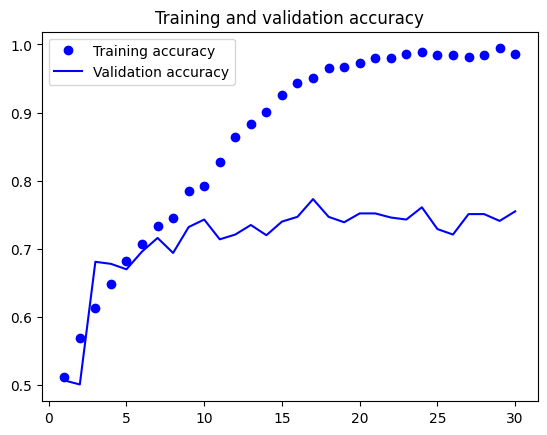

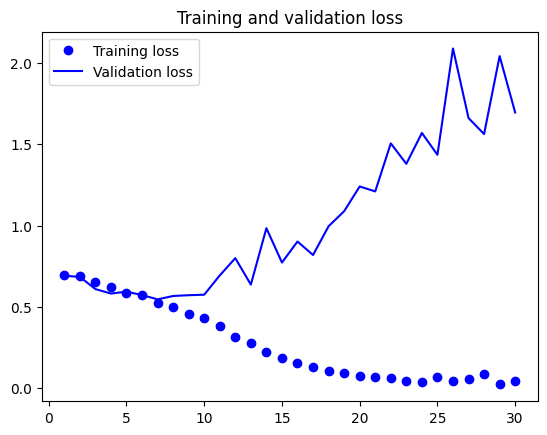

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.ckpt")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 10ms/step - loss: 0.5708 - accuracy: 0.7135
Test accuracy: 0.714


### Data augmentation

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

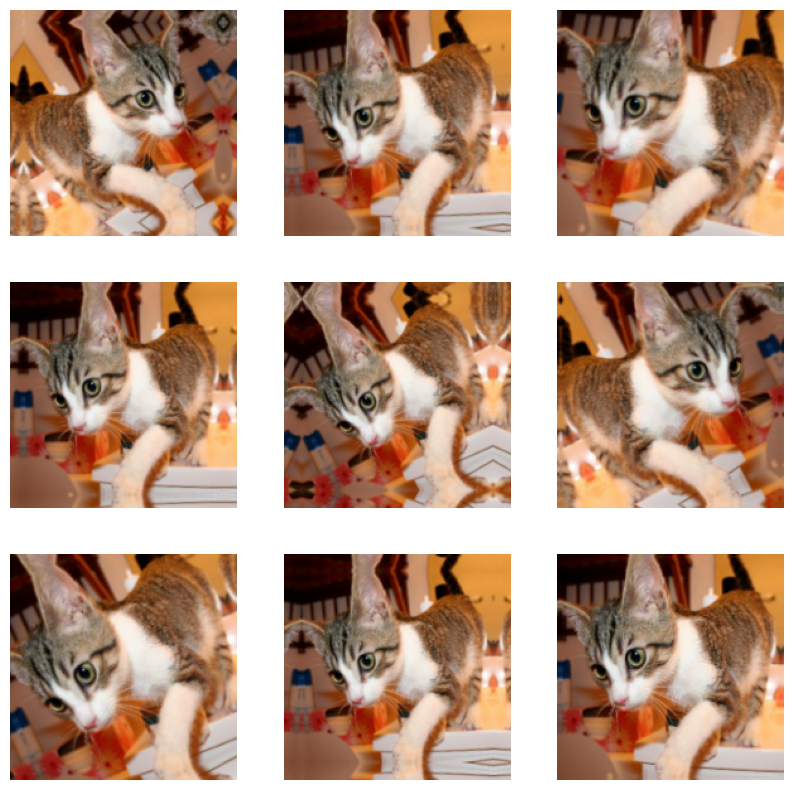

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.ckpt",
        save_best_only=True,
        options=None,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 6s 52ms/step - loss: 0.7021 - accuracy: 0.5270 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 3s 49ms/step - loss: 0.6941 - accuracy: 0.5080 - val_loss: 0.6859 - val_accuracy: 0.5150
Epoch 3/100
63/63 [==============================] - 2s 23ms/step - loss: 0.6847 - accuracy: 0.5455 - val_loss: 0.7260 - val_accuracy: 0.5080
Epoch 4/100
63/63 [==============================] - 4s 55ms/step - loss: 0.6820 - accuracy: 0.5770 - val_loss: 0.6748 - val_accuracy: 0.5880
Epoch 5/100
63/63 [==============================] - 3s 49ms/step - loss: 0.6597 - accuracy: 0.6275 - val_loss: 0.6252 - val_accuracy: 0.6480
Epoch 6/100
63/63 [==============================] - 3s 50ms/step - loss: 0.6258 - accuracy: 0.6465 - val_loss: 0.6002 - val_accuracy: 0.6720
Epoch 7/100
63/63 [==============================] - 2s 23ms/step - loss: 0.6254 - accuracy: 0.6705 - val_loss: 0.8121 - val_accuracy: 0.5500
Epoch 

In [23]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.ckpt")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 9ms/step - loss: 0.4420 - accuracy: 0.8220
Test accuracy: 0.822


### Feature extraction with a pretrained model

---



In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

#### Defining and training the densely connected classifier

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath = "feature_extraction.ckpt",
      save_best_only = True,
      monitor = "val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs = 20,
    validation_data = (val_features, val_labels),
    callbacks = callbacks)

Epoch 1/20
63/63 [==============================] - 2s 16ms/step - loss: 16.7503 - accuracy: 0.9250 - val_loss: 11.6795 - val_accuracy: 0.9290
Epoch 2/20
63/63 [==============================] - 1s 12ms/step - loss: 3.2893 - accuracy: 0.9785 - val_loss: 7.4511 - val_accuracy: 0.9630
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 1.4035 - accuracy: 0.9880 - val_loss: 7.7612 - val_accuracy: 0.9640
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0581 - accuracy: 0.9910 - val_loss: 11.4119 - val_accuracy: 0.9570
Epoch 5/20
63/63 [==============================] - 1s 13ms/step - loss: 1.1063 - accuracy: 0.9900 - val_loss: 4.2149 - val_accuracy: 0.9750
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 1.6595 - accuracy: 0.9890 - val_loss: 6.2759 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 1.4338 - accuracy: 0.9925 - val_loss: 6.7410 - val_accuracy: 0.9750
Epoch 8/20
63/

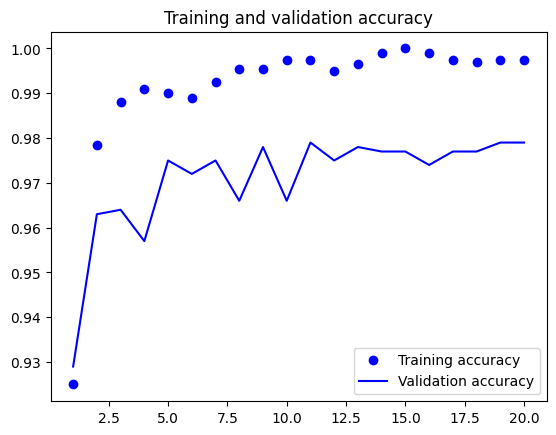

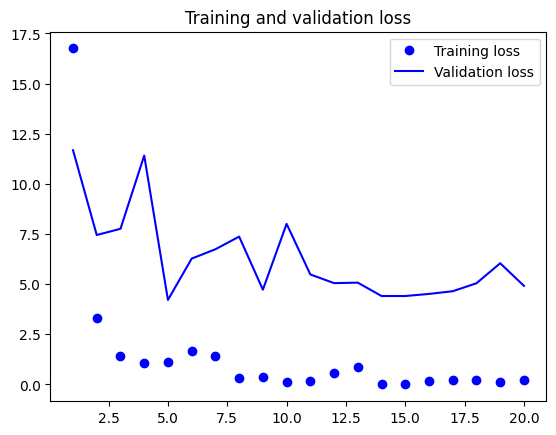

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Instantiating and freezing the VGG16 convolutional base

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False)
conv_base.trainable = False

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "feature_extraction_with_data_augmentation.ckpt",
        save_best_only = True,
        monitor = "val_loss")
]
history = model.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/50
63/63 [==============================] - 8s 98ms/step - loss: 15.8256 - accuracy: 0.9055 - val_loss: 3.3746 - val_accuracy: 0.9760
Epoch 2/50
63/63 [==============================] - 3s 51ms/step - loss: 7.9225 - accuracy: 0.9425 - val_loss: 4.1454 - val_accuracy: 0.9760
Epoch 3/50
63/63 [==============================] - 3s 50ms/step - loss: 6.0654 - accuracy: 0.9520 - val_loss: 5.3770 - val_accuracy: 0.9630
Epoch 4/50
63/63 [==============================] - 3s 50ms/step - loss: 5.5227 - accuracy: 0.9580 - val_loss: 4.6793 - val_accuracy: 0.9720
Epoch 5/50
63/63 [==============================] - 6s 93ms/step - loss: 4.7725 - accuracy: 0.9595 - val_loss: 3.0080 - val_accuracy: 0.9780
Epoch 6/50
63/63 [==============================] - 3s 51ms/step - loss: 5.0885 - accuracy: 0.9625 - val_loss: 4.1809 - val_accuracy: 0.9710
Epoch 7/50
63/63 [==============================] - 3s 51ms/step - loss: 4.0106 - accuracy: 0.9640 - val_loss: 3.1830 - val_accuracy: 0.9740
Epoch 8/50
6

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.ckpt")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 32ms/step - loss: 1.9419 - accuracy: 0.9780
Test accuracy: 0.978


#### Fine-tuning a pretrained model

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers until the fourth from the last

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.ckpt",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 8s 97ms/step - loss: 0.4847 - accuracy: 0.9895 - val_loss: 2.1354 - val_accuracy: 0.9720
Epoch 2/30
63/63 [==============================] - 3s 53ms/step - loss: 0.4629 - accuracy: 0.9890 - val_loss: 2.3180 - val_accuracy: 0.9760
Epoch 3/30
63/63 [==============================] - 3s 54ms/step - loss: 0.4124 - accuracy: 0.9885 - val_loss: 2.1591 - val_accuracy: 0.9760
Epoch 4/30
63/63 [==============================] - 6s 100ms/step - loss: 0.4365 - accuracy: 0.9875 - val_loss: 1.9217 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 3s 54ms/step - loss: 0.2661 - accuracy: 0.9930 - val_loss: 2.6798 - val_accuracy: 0.9720
Epoch 6/30
63/63 [==============================] - 3s 53ms/step - loss: 0.2253 - accuracy: 0.9920 - val_loss: 2.5198 - val_accuracy: 0.9760
Epoch 7/30
63/63 [==============================] - 3s 53ms/step - loss: 0.3182 - accuracy: 0.9920 - val_loss: 2.0187 - val_accuracy: 0.9780
Epoch 8/30
6

In [ ]:
model = keras.models.load_model("fine_tuning.ckpt")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 31ms/step - loss: 1.0979 - accuracy: 0.9795
Test accuracy: 0.979


### Residual connections

In [ ]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keithlowton","key":"f96b94ee8178d07d81a253c5457d447a"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_s")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters = 32, kernel_size = 5, use_bias = False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding = "same", use_bias = False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding = "same", use_bias = False)(x)

    x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)

    residual = layers.Conv2D(
        size, 1, strides = 2, padding = "same", use_bias = False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 180, 180, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 176, 176, 32)         2400      ['rescaling[0][0]']           
                                                                                              

In [ ]:
model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 20s 66ms/step - loss: 0.6997 - accuracy: 0.5655 - val_loss: 0.6934 - val_accuracy: 0.5150
Epoch 2/100
63/63 [==============================] - 3s 52ms/step - loss: 0.6541 - accuracy: 0.6095 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 3s 52ms/step - loss: 0.6535 - accuracy: 0.6085 - val_loss: 0.6921 - val_accuracy: 0.5190
Epoch 4/100
63/63 [==============================] - 3s 52ms/step - loss: 0.6293 - accuracy: 0.6390 - val_loss: 0.7076 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 3s 52ms/step - loss: 0.6198 - accuracy: 0.6545 - val_loss: 0.7059 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 3s 52ms/step - loss: 0.6113 - accuracy: 0.6800 - val_loss: 0.8217 - val_accuracy: 0.5100
Epoch 7/100
63/63 [==============================] - 3s 52ms/step - loss: 0.5879 - accuracy: 0.6890 - val_loss: 0.7470 - val_accuracy: 0.5040
Epoch

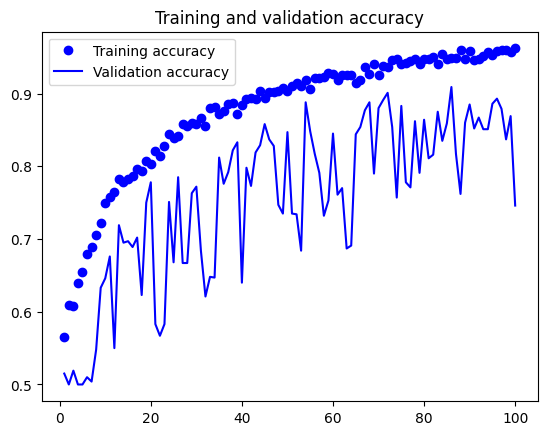

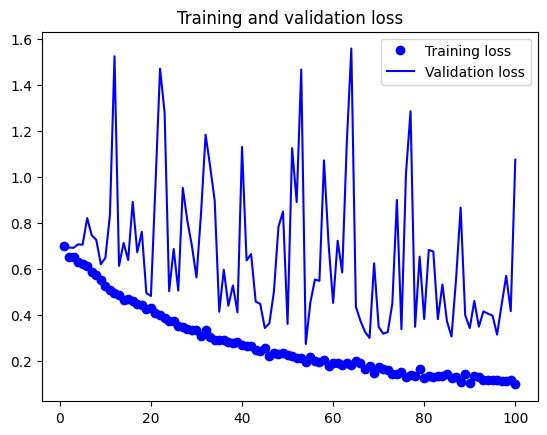

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 15ms/step - loss: 1.0401 - accuracy: 0.7440
Test accuracy: 0.744
